In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2

from tqdm import tqdm

from functions import *

In [2]:
# Returns the starting and ending points for the symmetry axis in cross symmetries as well as the coordinates for the bounding box
def getCrossSAandBB(img):
    minX = len(img[0])*10
    minY = -1
    maxX = -1
    maxY = -1
    for i in range(len(img)):
        for j in range(len(img[0])):
            if minY == -1 and (img[i][j][0] != 0 or img[i][j][1] != 0 or img[i][j][2] != 0):
                minY = i
            if img[i][j][0] != 0 or img[i][j][1] != 0 or img[i][j][2] != 0:
                maxY = i-1
                if j-1 > maxX:
                    maxX = j
                if j < minX:
                    minX = j
    maxX += 1
    maxY += 1

    # Axis of symmetry
    startAxis1 = (minX + (maxX-minX)//2, minY)            
    endAxis1 = (minX + (maxX-minX)//2, maxY)

    startAxis2 = (minX, minY + (maxY-minY)//2)            
    endAxis2 = (maxX, minY + (maxY-minY)//2)
    
    # Center, width and height of bounding box
    center = ((maxX-minX)/2+minX, (maxY-minY)/2+minY)
    height = (maxY-minY)
    width = (maxX-minX)
    
    return [[startAxis1, endAxis1],[startAxis2, endAxis2]],center,width,height


# Draws multiple symmetry axis and bounding box
def drawMultipleSAandBB(img, axes, center, width, height, rotation):
    for [startAxis, endAxis] in axes:
        # Symmetry axis
        cv2.line(img, (int(startAxis[0]) , int(startAxis[1])), (int(endAxis[0]) , int(endAxis[1])), [255,0,0], 1)

        # Points for bounding box
        pts = [(center[0]-width/2 , center[1]-height/2), (center[0]+width/2 , center[1]-height/2), 
            (center[0]+width/2 , center[1]+height/2), (center[0]-width/2 , center[1]+height/2)]
        
        # Rotating
        rotationMatrix = cv2.getRotationMatrix2D(center, rotation, 1)
        pts = transformKeypoints(pts, rotationMatrix)

        # Drawing bounding box
        displayBoundingBox(img, pts)

# Remove the excess padding from image
def removePaddingMultipleAxes(img, symAxes, cent):
    _,_, center, width, height = getSAandBB(img)
    minX = int(center[0] - width/2)
    minY = int(center[1] - height/2)
    maxX = int(center[0] + width/2)
    maxY = int(center[1] + height/2)
    cropped = img[minY:maxY, minX:maxX]
    newSymAxes = []
    for [startAxis, endAxis] in symAxes:
        newStartX = startAxis[0] - minX
        newStartY = startAxis[1] - minY
        newEndX = endAxis[0] - minX
        newEndY = endAxis[1] - minY
        newSymAxes.append([[newStartX, newStartY],[newEndX, newEndY]])
    newCentX = cent[0] - minX 
    newCentY = cent[1] - minY

    return cropped, newSymAxes, (newCentX, newCentY)

#Resizes the image and keypoints according to the selected percent
def resizeSymmetryMultipleAxes(percent, img, symAxes, center, inWidth, inHeight):
    width = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)

    newSymAxes = []
    for [startAxis, endAxis] in symAxes:
        newStartX = startAxis[0] * percent / 100
        newStartY = startAxis[1] * percent / 100
        newEndX = endAxis[0] * percent / 100
        newEndY = endAxis[1] * percent / 100
        newSymAxes.append([[newStartX, newStartY],[newEndX, newEndY]])
    newCenterX = center[0] * percent / 100
    newCenterY = center[1] * percent / 100
    newWidth = inWidth * percent / 100
    newHeight = inHeight * percent / 100

    return cv2.resize(img, (width, height)), newSymAxes, (newCenterX, newCenterY), newWidth, newHeight

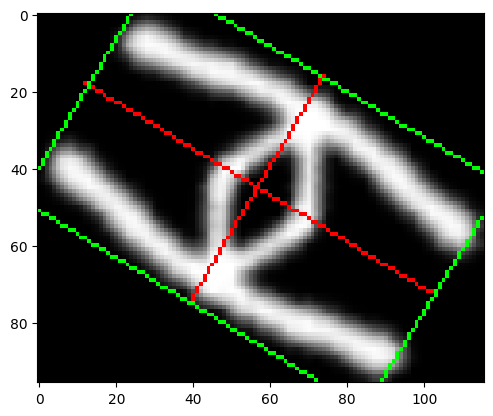

In [5]:
minst = pd.read_csv('MNIST/mnist_test.csv')

def createCrossSymmetry(id,minst,initialRotation = None, overFlow = None, padding1 = None, padding2 = None, finalRotation = None, 
                        resizingPercent = None):
    result,label = getImageArray(id,minst)

    # Initial rotation
    if initialRotation is None:
        initialRotation = random.randrange(360)
    result,_ = rotateDigit(result, initialRotation)

    # Vertically mirroring the image
    mirrored = cv2.flip(result, 1)

    # Combining initial with mirrored 
    if overFlow is None:
        overFlow = bool(random.getrandbits(1))
    if padding1 is None:
        padding1 = random.randrange(-result.shape[0], result.shape[0])
    result = addWithPadding(result,mirrored, padding1, overFlow=overFlow)

    # Horizontally mirroring the image
    mirrored = cv2.flip(result, 0)

    # Rotating both images 90º so they can be added with function
    mirrored = cv2.rotate(mirrored, cv2.ROTATE_90_CLOCKWISE)
    result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    # Combining initial with mirrored
    if padding2 is None:
        padding2 = random.randrange(-result.shape[0], result.shape[0])
    result = addWithPadding(result,mirrored, padding1, overFlow=overFlow)
    
    # Adding padding for rotation
    result = addRotationPadding(result)

    # Obtaining symmetry axes
    symAxes, center, width, height = getCrossSAandBB(result)

    # Final rotation
    if finalRotation is None:
        finalRotation = random.randrange(360)
    result,rotationMatrix = rotateDigit(result,finalRotation)

    # Rotating symmetry axis
    rotated = transformKeypoints([symAxes[0][0], symAxes[0][1], symAxes[1][0], symAxes[1][1], center], rotationMatrix)
    symAxes[0][0] = rotated[0]
    symAxes[0][1] = rotated[1]
    symAxes[1][0] = rotated[2]
    symAxes[1][1] = rotated[3]
    center = rotated[4]

    # Remove excess pading
    result, symAxes, center = removePaddingMultipleAxes(result, symAxes, center)

    # Resizing
    if resizingPercent is None:
        resizingPercent = random.randrange(80,300)
    result, symAxes, center, width, height = resizeSymmetryMultipleAxes(resizingPercent, result, symAxes, center, width, height)

    return result, {'symAxes':symAxes, 'center':center, 'width':width, 'height':height, 'label':label, 'initialRotation':initialRotation, 'overFlow':overFlow,
                    'padding1':padding1, 'padding2': padding2, 'finalRotation':finalRotation, 'resizingPercent':resizingPercent}

   


img, dict = createCrossSymmetry(34, minst)

display = img.copy()
drawMultipleSAandBB(display, dict['symAxes'], dict['center'], dict['width'], dict['height'], dict['finalRotation'])
plt.imshow(display)